In [937]:
import pycuda.autoinit
import pycuda.driver as drv
import numpy as np

import matplotlib.pyplot as plt

%matplotlib inline

from pycuda.compiler import SourceModule
with open("./primitives.cu", "r") as f:
    mod = SourceModule(f.read())

In [938]:
mod

In [939]:
cphase = mod.get_function("cphase")
hadamard = mod.get_function("hadamard")
amp_ph_damping = mod.get_function("amp_ph_damping")

In [940]:
x = (np.random.random((32*32,32*32))+2 )*(1+1j)
x[:,:] = 1
x = x.astype(np.complex128)
x = x/np.trace(x)

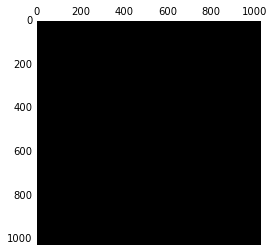

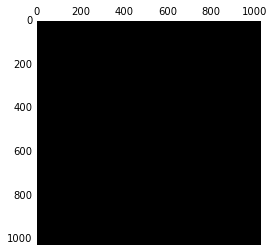

In [941]:
plt.matshow(x.real, cmap="gray")
plt.matshow(x.imag, cmap="gray")

In [942]:
xg = drv.to_device(x)

In [670]:
cphase(xg, np.uint32((1<<9) | (1<<6)), block=(32,32,1), grid=(32,32,1))

In [671]:
hadamard(xg, np.uint32(1<<9), np.float32(0.5), block=(32,32,1), grid=(32,32,1))

In [672]:
#cnot
hadamard(xg, np.uint32(1<<9), np.float32(0.5), block=(32,32,1), grid=(32,32,1))
cphase(xg, np.uint32((1<<9) | (1<<8)), block=(32,32,1), grid=(32,32,1))
hadamard(xg, np.uint32(1<<9), np.float32(0.5), block=(32,32,1), grid=(32,32,1))


In [943]:
gamma = 0.1
lamda = 0.0

gamma = np.float64(gamma)
s1mgamma = np.float64(np.sqrt(1 - gamma))
s1mlambda = np.float64(np.sqrt(1 - lamda))

for i in range(1000):
    amp_ph_damping(xg, np.uint32(1<<0), gamma, s1mgamma, s1mlambda, block=(32,32,1), grid=(32,32,1))

In [950]:
%timeit cphase(xg, np.uint32((1<<9) | (1<<6)), block=(32,32,1), grid=(32,32,1))

10000 loops, best of 3: 135 µs per loop


In [949]:
%timeit hadamard(xg, np.uint32(1<<9), np.float64(0.5), block=(32,32,1), grid=(32,32,1))


10000 loops, best of 3: 410 µs per loop


In [944]:
xp = drv.from_device(xg, (32*32,32*32), np.complex128)

In [945]:
np.trace(xp)

(0.99999999999999956+0j)

In [952]:
%timeit amp_ph_damping(xg, np.uint32(1<<0), gamma, s1mgamma, s1mlambda, block=(32,32,1), grid=(32,32,1))

10000 loops, best of 3: 413 µs per loop


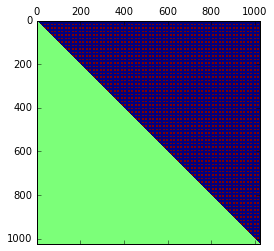

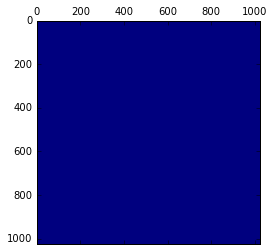

In [951]:
plt.matshow(xp.real)
plt.matshow(xp.imag)